<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/TestBATCHT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
#import libraries
import torch
import torch.nn as nn

import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader


<ipython-input-62-18bbc7a40f3b>:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


Create the data

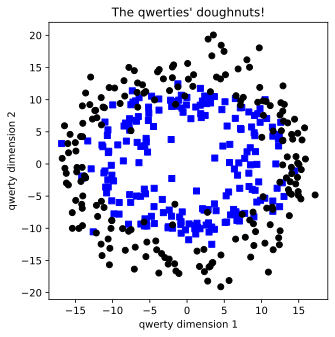

In [63]:
#create data
nPerClust=200
th=np.linspace(0,4*np.pi,nPerClust)
r1=10
r2=15
#generate data
a=[r1*np.cos(th)+np.random.randn(nPerClust)*3,r1*np.sin(th)+np.random.randn(nPerClust)]
b=[r2*np.cos(th)+np.random.randn(nPerClust),r2*np.sin(th)+np.random.randn(nPerClust)*3]
#true labels
labels_np=np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))
#concatanate into a matrix
data_np=np.hstack((a,b)).T
#convert to a pytorch tensor
data=torch.tensor(data_np).float()
labels=torch.tensor(labels_np).float()
#show the data
fig=plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

Seperate the data into dataloader


In [64]:
#use scikitlearn to split the data
train_data,test_data,train_labels,test_labels=train_test_split(data,labels,test_size=0.1)
#then convert them into Pytorch Datasets(note:already converted to tensors)
train_data=TensorDataset(train_data,train_labels)
test_data=TensorDataset(test_data,test_labels)
#finally, translate into dataloader objects
train_batchsize = 16
train_loader = DataLoader(train_data, batch_size=train_batchsize, shuffle=True,drop_last=True)
test_batchsize=test_data.tensors[0].shape[0]-2
test_loader = DataLoader(test_data, batch_size=test_batchsize)

In [65]:
for X,y in test_loader:
  print(X.shape,y.shape)

torch.Size([38, 2]) torch.Size([38, 1])
torch.Size([2, 2]) torch.Size([2, 1])


Create the model

In [66]:
class theModelClass(nn.Module):
  def __init__(self):
    super().__init__()
    ##layers
    self.input=nn.Linear(2,128)
    self.hidden=nn.Linear(128,128)
    self.output=nn.Linear(128,1)
    #parameters
  #forwardpass
  def forward(self,x):
    #pass the data through the input layer
    x=self.input(x)
    x=F.relu(x)

    #pass the data through the hidden layer
    x=self.hidden(x)
    x=F.relu(x)

    x=self.output(x)
    #no dropout because only one hidden layer
    return x




Functions to create and train the net

In [67]:
def createANewModel():
  #grad the instance of the model class
  ANNQC=theModelClass()
  #loss function
  lossfun=nn.BCEWithLogitsLoss()
  #optimizer
  optimizer=torch.optim.SGD(ANNQC.parameters(),lr=0.01)
  return ANNQC,lossfun,optimizer

In [68]:
#train the model
#training parameter
numepochs=500
#NOTE: this time, the model, lossfun and optimizer are inputs into the function
def trainTheModel(ANNQC,lossfun,optimizer):
  #initialize accuracies as empties(not storing losses here)
  trainAcc=[]
  testAcc=[]
  #loop over epochs
  for epochi in range(numepochs):
    #loop over training data batches
    batchAcc=[]
    #switch training mode on
    for X,y in train_loader :
      #forward pass and loss
      yHat=ANNQC(X)
      loss=lossfun(yHat,y)
      #backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #compute accuracy
      batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
    #end of batch loop....
    #now that we've trained through the batches. get their training accuracy
    trainAcc.append(np.mean(batchAcc))
    tstAcc=[]
    #TEST ACCURACY
    for X,y in test_loader:
      yHat=ANNQC(X)
      tstAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
    #now get the average accuracy over test-batches
    testAcc.append(np.mean(tstAcc))

  #function output
  return trainAcc,testAcc

TEST THE MODEL

In [69]:
#create a model
ANNQC,lossfun,optimizer=createANewModel()
#train the model(note the inputs!)
trainAcc,testAcc=trainTheModel(ANNQC,lossfun,optimizer)


In [70]:
#create a 1D smoothing filter
def smooth(x, k=5):
    return np.convolve(x, np.ones(k)/k, mode='same')

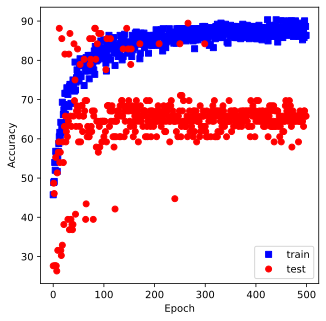

In [72]:
#plot the result
fig=plt.figure(figsize=(5,5))
plt.plot((trainAcc),'bs')
plt.plot((testAcc),'ro')
plt.legend(['train','test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


Now for the test